In [5]:
# Import Packages
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import os
import sys
import dtale
# import holidays

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go

from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error

%matplotlib inline


# Folder Structure
SCRIPT_DIR = (os.path.dirname(os.path.realpath("__file__")))
DATA_DIR = os.path.join(os.path.dirname(SCRIPT_DIR), "data")

# Read Data
train = pd.read_csv(f"{DATA_DIR}/train_F3fUq2S.csv")
test = pd.read_csv(f"{DATA_DIR}/test_Bk2wfZ3.csv")

print(train.shape, test.shape)
train.sample()

(1888, 22) (762, 21)


,campaign_id,sender,subject_len,body_len,mean_paragraph_len,day_of_week,is_weekend,times_of_day,category,product,no_of_CTA,mean_CTA_len,is_image,is_personalised,is_quote,is_timer,is_emoticons,is_discount,is_price,is_urgency,target_audience,click_rate
1068,1069,3,91,13855,36,3,0,Evening,15,9,4,28,1,0,0,0,0,0,0,0,15,0.006748


In [3]:
test.sample()

,campaign_id,sender,subject_len,body_len,mean_paragraph_len,day_of_week,is_weekend,times_of_day,category,product,...,mean_CTA_len,is_image,is_personalised,is_quote,is_timer,is_emoticons,is_discount,is_price,is_urgency,target_audience
115,2004,3,87,9691,55,5,1,Evening,15,9,...,32,1,0,1,0,2,0,0,0,7


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1888 entries, 0 to 1887
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   campaign_id         1888 non-null   int64  
 1   sender              1888 non-null   int64  
 2   subject_len         1888 non-null   int64  
 3   body_len            1888 non-null   int64  
 4   mean_paragraph_len  1888 non-null   int64  
 5   day_of_week         1888 non-null   int64  
 6   is_weekend          1888 non-null   int64  
 7   times_of_day        1888 non-null   object 
 8   category            1888 non-null   int64  
 9   product             1888 non-null   int64  
 10  no_of_CTA           1888 non-null   int64  
 11  mean_CTA_len        1888 non-null   int64  
 12  is_image            1888 non-null   int64  
 13  is_personalised     1888 non-null   int64  
 14  is_quote            1888 non-null   int64  
 15  is_timer            1888 non-null   int64  
 16  is_emo

In [6]:
train.sample()

,campaign_id,sender,subject_len,body_len,mean_paragraph_len,day_of_week,is_weekend,times_of_day,category,product,no_of_CTA,mean_CTA_len,is_image,is_personalised,is_quote,is_timer,is_emoticons,is_discount,is_price,is_urgency,target_audience,click_rate
1685,1686,3,83,18967,13,1,0,Evening,10,42,1,29,0,0,0,0,0,0,0,0,14,0.08877


In [16]:
train['target_audience'].value_counts()

12    1169
14     175
10     136
16     132
15      61
7       56
1       50
2       20
5       16
6       14
11      12
4       10
13      10
3        9
8        9
9        6
0        3
Name: target_audience, dtype: int64

In [19]:
# Select features for training
idx = [
    'campaign_id'
]

cat_features = [
    'sender',
    'day_of_week',
    'is_weekend',
    'times_of_day',
    'category',
    'product',
    'is_personalised',
    # 'is_timer',
    'is_discount',
    'is_urgency',
    'target_audience'
]

num_features = [
    'subject_len',
    'body_len',
    'mean_paragraph_len',
    'no_of_CTA',
    'mean_CTA_len',
    'is_image',
    'is_quote',
    'is_emoticons',
    'is_price'
]

features = cat_features+num_features

target = 'click_rate'

# Xy = train.set_index(idx)[features + [target]]
# print(Xy.shape)
# Xy.sample()

(1888, 20)


,sender,day_of_week,is_weekend,times_of_day,category,product,is_personalised,is_discount,is_urgency,target_audience,subject_len,body_len,mean_paragraph_len,no_of_CTA,mean_CTA_len,is_image,is_quote,is_emoticons,is_price,click_rate
campaign_id,,,,,,,,,,,,,,,,,,,,
1180,11,1,0,Evening,15,9,0,0,1,12,90,23102,20,4,33,0,1,0,0,0.006959


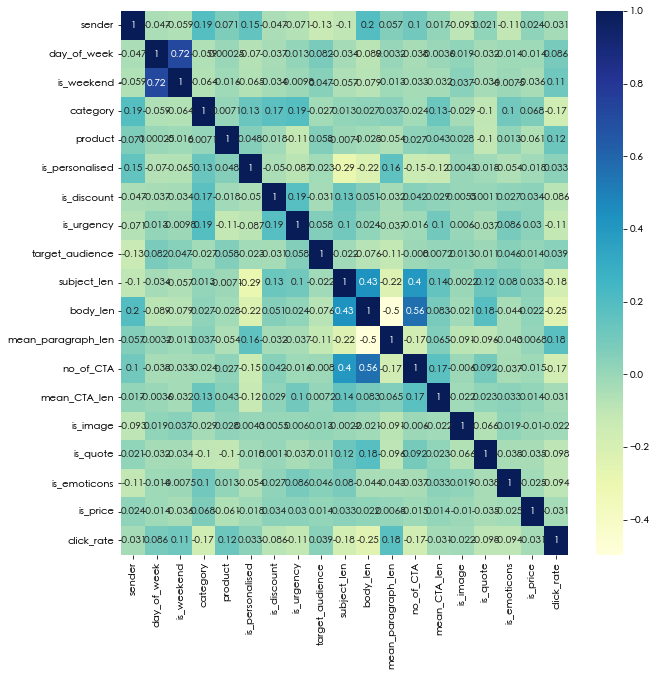

In [20]:
# Correlation plot
%matplotlib inline
plt.figure(figsize=(10,10))
sns.heatmap(Xy.corr(), cmap="YlGnBu", annot=True)
plt.show()

In [27]:
train_catboost = train
test_catboost = test

feature_target_mapping = {
    'idx_cols': idx,
    'num_features': num_features,
    'cat_features': cat_features,
    'target': target
}

import json
print(json.dumps(feature_target_mapping, indent=4))



for col in feature_target_mapping['cat_features']:

    train_catboost[col] = train_catboost[col].astype(str)
    test_catboost[col] = test_catboost[col].astype(str)
    
for col in feature_target_mapping['num_features']:

    train_catboost[col] = train_catboost[col].astype(float)
    test_catboost[col] = test_catboost[col].astype(float)


Xy = train_catboost[features + [target]]
X = Xy.reindex(features, axis=1)
y = Xy.reindex([target], axis=1)
print(Xy.shape)


# Random Sampling

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)


print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)

{
    "idx_cols": [
        "campaign_id"
    ],
    "num_features": [
        "subject_len",
        "body_len",
        "mean_paragraph_len",
        "no_of_CTA",
        "mean_CTA_len",
        "is_image",
        "is_quote",
        "is_emoticons",
        "is_price"
    ],
    "cat_features": [
        "sender",
        "day_of_week",
        "is_weekend",
        "times_of_day",
        "category",
        "product",
        "is_personalised",
        "is_discount",
        "is_urgency",
        "target_audience"
    ],
    "target": "click_rate"
}
(1888, 20)
(1057, 19) (1057, 1) (453, 19) (453, 1) (378, 19) (378, 1)


In [28]:
# ---------------------
# Train-Val-Test Pools
# ---------------------

from catboost import Pool

# initialize Pool
full_pool = Pool(
  X,
  y,
  cat_features=feature_target_mapping['cat_features']
)

train_pool = Pool(
  X_train,
  y_train,
  cat_features=feature_target_mapping['cat_features']
)
val_pool = Pool(
  X_val,
  y_val,
  cat_features=feature_target_mapping['cat_features']
)
test_pool = Pool(
  X_test, 
  cat_features=feature_target_mapping['cat_features']
)

# Submission Pool
test_catboost_pool = Pool(
  test_catboost.reindex(features, axis=1),
  cat_features=feature_target_mapping['cat_features']
)


In [48]:
version = 0.1
iterations = 10000
max_depth = 10
learning_rate = 0.01
eval_metric = 'R2'
early_stopping_rounds = 100
# l2_leaf_reg = 1

# ---------------------
# Regression
# ---------------------

from catboost import CatBoostRegressor #, cv

model = CatBoostRegressor(
    iterations=iterations,
    max_depth=max_depth,
    learning_rate=learning_rate,
    eval_metric=eval_metric,
    verbose=False,
    early_stopping_rounds=early_stopping_rounds,
    # l2_leaf_reg = l2_leaf_reg,
    random_seed=42
)

# train the model
model.fit(train_pool, eval_set=val_pool, plot=True) # 

feature_imp_df = pd.DataFrame.from_dict(dict(zip(model.feature_names_, model.feature_importances_)), orient='index', columns=['importance']).reset_index().rename(columns={'index': 'feature'}).sort_values('importance', ascending=False)
feature_imp_df


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

,feature,importance
11,body_len,19.529801
13,no_of_CTA,11.022475
9,target_audience,10.505534
4,category,8.214348
3,times_of_day,8.017290
10,subject_len,6.926971
14,mean_CTA_len,6.622865
5,product,6.426437
1,day_of_week,6.326352
12,mean_paragraph_len,5.347777


In [49]:
# Predict and Evaluate catboost model
y_pred = model.predict(X_test)

def get_regression_eval_metrics(y_test, y_pred):
    
    from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test,y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    print("R^2 : ", r2)
    print("MAE :", mae)
    print("RMSE:", rmse)
    
    return np.round(r2, 2), int(np.round(mae, 0)), int(np.round(rmse, 0))

r2, mae, rmse = get_regression_eval_metrics(y_test, y_pred)


R^2 :  0.45793605361096723
MAE : 0.02885458863653355
RMSE: 0.04897558789809539


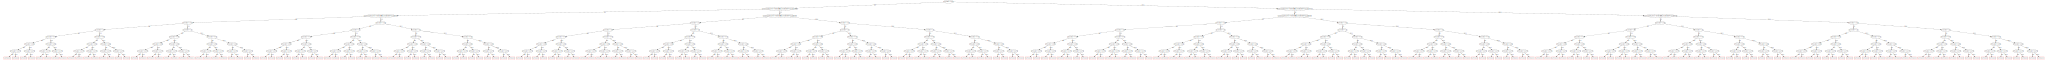

In [34]:
model.plot_tree(1)

In [47]:
# Save file for submission
test_catboost[target] = model.predict(test_catboost[features])

submission = test_catboost.reset_index()[idx+[target]]

submission.to_csv(f'{DATA_DIR}/v{version}_cbr_{eval_metric}_{max_depth}_{early_stopping_rounds}_{learning_rate}-{rmse}_{mae}_{r2}.csv', index=False)